In [1]:
#
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/bvsm.m
#
# I had trouble fitting relative error sum(lc/lc_pred - 1)^2 as done in the example
# So I chose minimizing sum(lc - lc_pred)^2. Still I had trouble with collocation. But finite difference
# discretization worked.

In [2]:
# Import libraries
from pyomo.environ import *
from pyomo.dae import *
import pyomo.contrib.parmest.parmest as parmest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [3]:
# load flow rate data
flow_data = pd.read_csv('flow_data.csv')
lc_data = pd.read_csv('lc_data.csv')
teaf      = 0.00721
teaden    = 0.728
cBf = teaf

In [4]:
tQf = np.insert(flow_data['t'].values, 0, 0)
Qf = np.insert(flow_data["Qf"].values / teaden, 0, 0)

In [5]:
tlc = lc_data['t'].values
lc = lc_data['lc_meas'].values

In [6]:
tout = np.sort(np.unique(np.concatenate((tQf, tlc))))

In [7]:
max(tout)

869

In [8]:
Qf_if = interp1d(tQf, Qf, 'previous', bounds_error = False)
lc_if = interp1d(tlc, lc, 'previous', bounds_error = False)

In [9]:
data = [{'tout': tout, 'tlc': tlc, 'Qf_if': Qf_if, 'lc':lc, 'cBf': cBf}]

In [10]:
def bvsm_model(data):
    
    tout = data['tout']
    tlc = data['tlc']
    Qf_if = data['Qf_if']
    lc_m = data['lc']
    cBf = data['cBf']
    
    Vr0 = 2370
    nB0 = 0
    nC0 = 0
    nD0 = 0
    
    m = ConcreteModel()
    
    m.k1 = Var(initialize = 2000, bounds = (500, 5000))
    m.k2 = Var(initialize = 1000, bounds = (500, 5000))
    m.nA0 = Var(initialize = 2.35, bounds = (2, 3))
    
    m.time = ContinuousSet(bounds = (0, max(tout)), initialize = tout)
    
    m.Vr = Var(m.time, initialize = Vr0, bounds = (Vr0,None))
    m.nA = Var(m.time, initialize = 2.35, bounds = (0, 2.35))
    m.nB = Var(m.time, initialize = nB0, bounds = (0, 2.35))
    m.nC = Var(m.time, initialize = nC0, bounds = (0, 2.35))
    m.nD = Var(m.time, initialize = nD0, bounds = (0, 2.35))
    m.y = Var(m.time, initialize = 0.5, bounds = (0, 1))
    
    m.dVr = DerivativeVar(m.Vr)
    m.dnA = DerivativeVar(m.nA)
    m.dnB = DerivativeVar(m.nB)
    m.dnC = DerivativeVar(m.nC)
    m.dnD = DerivativeVar(m.nD)
    
    def _dVr_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dVr[t] == float(Qf_if(t))
    m.dVr_eq = Constraint(m.time, rule = _dVr_eq)
    
    def _dnA_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dnA[t] == -m.k1 * m.nA[t] * m.nB[t] / m.Vr[t]
    m.dnA_eq = Constraint(m.time, rule = _dnA_eq)

    def _dnB_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dnB[t] == float(Qf_if(t)) * cBf - (m.k1 * m.nA[t] * m.nB[t] + m.k2 * m.nB[t] * m.nC[t]) / m.Vr[t]
    m.dnB_eq = Constraint(m.time, rule = _dnB_eq)
    
    def _dnC_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dnC[t] == (m.k1 * m.nA[t] * m.nB[t] - m.k2 * m.nB[t] * m.nC[t]) / m.Vr[t]
    m.dnC_eq = Constraint(m.time, rule = _dnC_eq)
    
    def _dnD_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dnD[t] == m.k2 * m.nB[t] * m.nC[t] / m.Vr[t]
    m.dnD_eq = Constraint(m.time, rule = _dnD_eq)
    
    def _ycalc(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.y[t] == m.nC[t] / (m.nC[t] + 2 * m.nD[t] + 1.0e-6)
    m.ycalc = Constraint(m.time, rule = _ycalc)
    
    def _initcon(m):
        yield m.Vr[m.time.first()] == Vr0
        yield m.nA[m.time.first()] == m.nA0
        yield m.nB[m.time.first()] == nB0
        yield m.nC[m.time.first()] == nC0
        yield m.nD[m.time.first()] == nD0
    m.initcon = ConstraintList(rule = _initcon)
    
    def ComputeFirstStageCost_rule(m):
        return 0
    m.FirstStageCost = Expression(rule=ComputeFirstStageCost_rule)

    def ComputeSecondStageCost_rule(m):
#        return sum((float(lc_if(t)) / m.y[t] - 1.0) ** 2 for t in tlc) 
        return sum((float(lc_if(t)) - m.y[t]) ** 2 for t in tlc) 
    m.SecondStageCost = Expression(rule=ComputeSecondStageCost_rule)
   
    def total_cost_rule(model):
        return model.FirstStageCost + model.SecondStageCost
    m.Total_Cost_Objective = Objective(rule=total_cost_rule, sense=minimize)
    
    #disc = TransformationFactory('dae.collocation')
    #disc.apply_to(m, nfe=200, ncp=2)
    
    disc = TransformationFactory('dae.finite_difference')
    disc.apply_to(m, nfe=500, scheme = 'BACKWARD')
    
    return m

In [11]:
# parameters to be estimated
theta_names = ['k1', 'k2', 'nA0']

In [12]:
pest = parmest.Estimator(bvsm_model, data, theta_names, tee = True)

In [18]:
res = pest.theta_est(calc_cov = True)

Ipopt 3.12: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    21512
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     7535

Total number of variables............................:     5511
                     variables with only lower bounds:      501
                variables with lower and upper bounds:     2507
                     variables with only upper bounds:        0
Total number of equality constraints......

  68r 1.9260920e-03 4.30e-05 1.00e+03  -4.4 0.00e+00  19.1 0.00e+00 0.00e+00R  1
  69r 2.0399208e-03 4.29e-05 8.85e+04  -4.4 2.08e+01    -  1.85e-02 9.99e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.0398362e-03 4.28e-05 6.01e+02  -8.6 4.92e-01    -  6.48e-01 1.15e-03h  1
  71  1.9932855e-03 7.05e-08 1.52e+07  -8.6 4.32e-01    -  8.89e-03 1.00e+00h  1
  72  1.9898758e-03 1.04e-10 4.49e+06  -8.6 5.28e-02    -  1.00e+00 1.00e+00h  1
  73  1.4580959e-03 4.73e-05 6.45e+08  -8.6 5.54e+01    -  8.58e-01 9.44e-01f  1
In iteration 73, 1 Slack too small, adjusting variable bound
  74  1.4580912e-03 4.73e-05 1.40e+12  -8.6 3.44e+01    -  5.58e-01 4.12e-05h  1
  75  1.2769806e-03 1.26e-04 1.11e+13  -8.6 1.03e+02    -  1.04e-01 9.00e-01h  1
  76r 1.2769806e-03 1.26e-04 1.00e+03  -3.9 0.00e+00    -  0.00e+00 0.00e+00R  1
  77r 1.2808897e-03 1.25e-04 6.31e+04  -3.9 6.78e+01    -  1.34e-02 9.93e-04f  1
  78  1.2842054e-03 2.55e-07 2.85e+06  -8.6 1.73

ValueError: Cannot load a SolverResults object with bad status: error

In [14]:
theta

{'k1': 1563.984736856912, 'k2': 758.7374011550746, 'nA0': 2.3426178392738235}

In [15]:
ms = bvsm_model(data[0])
ms.k1.fix(theta['k1'])
ms.k2.fix(theta['k2'])
ms.nA0.fix(theta['nA0'])
solver = SolverFactory('ipopt')
solver.solve(ms, tee = True)

Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    18505
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4535

Total number of variables............................:     5505
                     variables with only lower bounds:      501
                variables with lower and upper bounds:     2504
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5505
Total number of inequali

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 5505, 'Number of variables': 5505, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.31673526763916016}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

(0.0, 0.2)

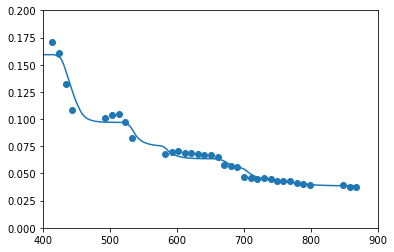

In [16]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.y[t]() for t in ms.time])
ax.scatter(data[0]['tlc'], data[0]['lc'])
ax.set_xlim(400, 900)
ax.set_ylim(0, 0.2)